In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import arviz as az

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Hard

## 7H1

In [36]:
df = pd.read_csv('/Users/benjaminwee/Documents/courses/resources/Rethinking/Data/tulips.csv',
                sep = ';',
                header = 0)
df.info()
df.head()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
bed       27 non-null object
water     27 non-null int64
shade     27 non-null int64
blooms    27 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 992.0+ bytes


,water,shade,blooms
count,27.00000,27.00000,27.000000
mean,2.00000,2.00000,128.993704
std,0.83205,0.83205,92.683923
min,1.00000,1.00000,0.000000
25%,1.00000,1.00000,71.115000
50%,2.00000,2.00000,111.040000
75%,3.00000,3.00000,190.300000
max,3.00000,3.00000,361.660000


In [37]:
# Centre predictors 
df['water'] = df.water - df.water.mean()
df['shade'] = df.shade - df.shade.mean()

In [38]:
tulips = pd.concat([df, pd.get_dummies(df['bed'])], axis = 1)
tulips.head()

,bed,water,shade,blooms,a,b,c
0,a,-1.0,-1.0,0.00,1,0,0
1,a,-1.0,0.0,0.00,1,0,0
2,a,-1.0,1.0,111.04,1,0,0
3,a,0.0,-1.0,183.47,1,0,0
4,a,0.0,0.0,59.16,1,0,0


In [39]:
with pm.Model() as m_h1:
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    bBa = pm.Normal('bBa', mu = 1, sd = 1)
    bBb = pm.Normal('bBb', mu = 1, sd = 1)
    bBc = pm.Normal('bBc', mu = 1, sd = 1)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    mu = pm.Deterministic('mu', bW*tulips.water + bS*tulips.shade + bBa*tulips.a + bBb*tulips.b + bBc*tulips.c)
    blooms = pm.Normal('blooms', mu, sigma, observed=tulips.blooms)
    trace_m_h1 = pm.sample(1000, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bBc, bBb, bBa, bS, bW]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2037.14draws/s]
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7128855610952172, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6353333200015348, but should be close to 0.8. Try to increase the number of tuning steps.


In [40]:
az.summary(trace_m_h1, ['~mu'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bW,72.093,22.558,31.498,115.405,0.371,0.266,3694.0,3597.0,3697.0,2903.0,1.0
bS,-39.594,22.981,-79.388,5.780,0.395,0.291,3377.0,3116.0,3381.0,2788.0,1.0
bBa,1.108,1.008,-0.727,3.014,0.016,0.013,3799.0,2847.0,3806.0,2710.0,1.0
bBb,1.086,1.011,-0.732,2.989,0.017,0.013,3448.0,2856.0,3432.0,2773.0,1.0
bBc,1.136,1.012,-0.795,3.065,0.017,0.013,3719.0,2895.0,3728.0,2896.0,1.0
sigma,97.213,2.618,92.441,99.999,0.051,0.036,2661.0,2661.0,2761.0,2114.0,1.0


In [41]:
with pm.Model() as m_h1_2:
    a = pm.Normal('a', mu = 1, sd =100)
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    mu = pm.Deterministic('mu', a + bW*tulips.water + bS*tulips.shade)
    blooms = pm.Normal('blooms', mu, sigma, observed=tulips.blooms)
    trace_m_h1_2 = pm.sample(1000, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bS, bW, a]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2327.16draws/s]
The acceptance probability does not match the target. It is 0.8995241470924864, but should be close to 0.8. Try to increase the number of tuning steps.


In [42]:
az.summary(trace_m_h1_2, ['~mu'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,127.294,12.317,102.549,148.993,0.211,0.151,3414.0,3347.0,3434.0,2370.0,1.0
bW,74.040,15.310,43.682,102.245,0.266,0.192,3303.0,3190.0,3277.0,2531.0,1.0
bS,-40.592,15.096,-68.815,-11.911,0.279,0.206,2923.0,2695.0,2906.0,2438.0,1.0
sigma,63.988,9.657,47.557,82.854,0.202,0.150,2294.0,2082.0,2631.0,1642.0,1.0


## 7H2

In [43]:
compare = az.compare({'m_h1' : trace_m_h1,
                     'm_h1_2' : trace_m_h1_2})
compare

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_h1_2,0,303.906,3.70161,0,1,9.37598,0,True,deviance
m_h1,1,360.001,4.60252,56.0947,1.48987e-09,6.87251,9.2639,True,deviance


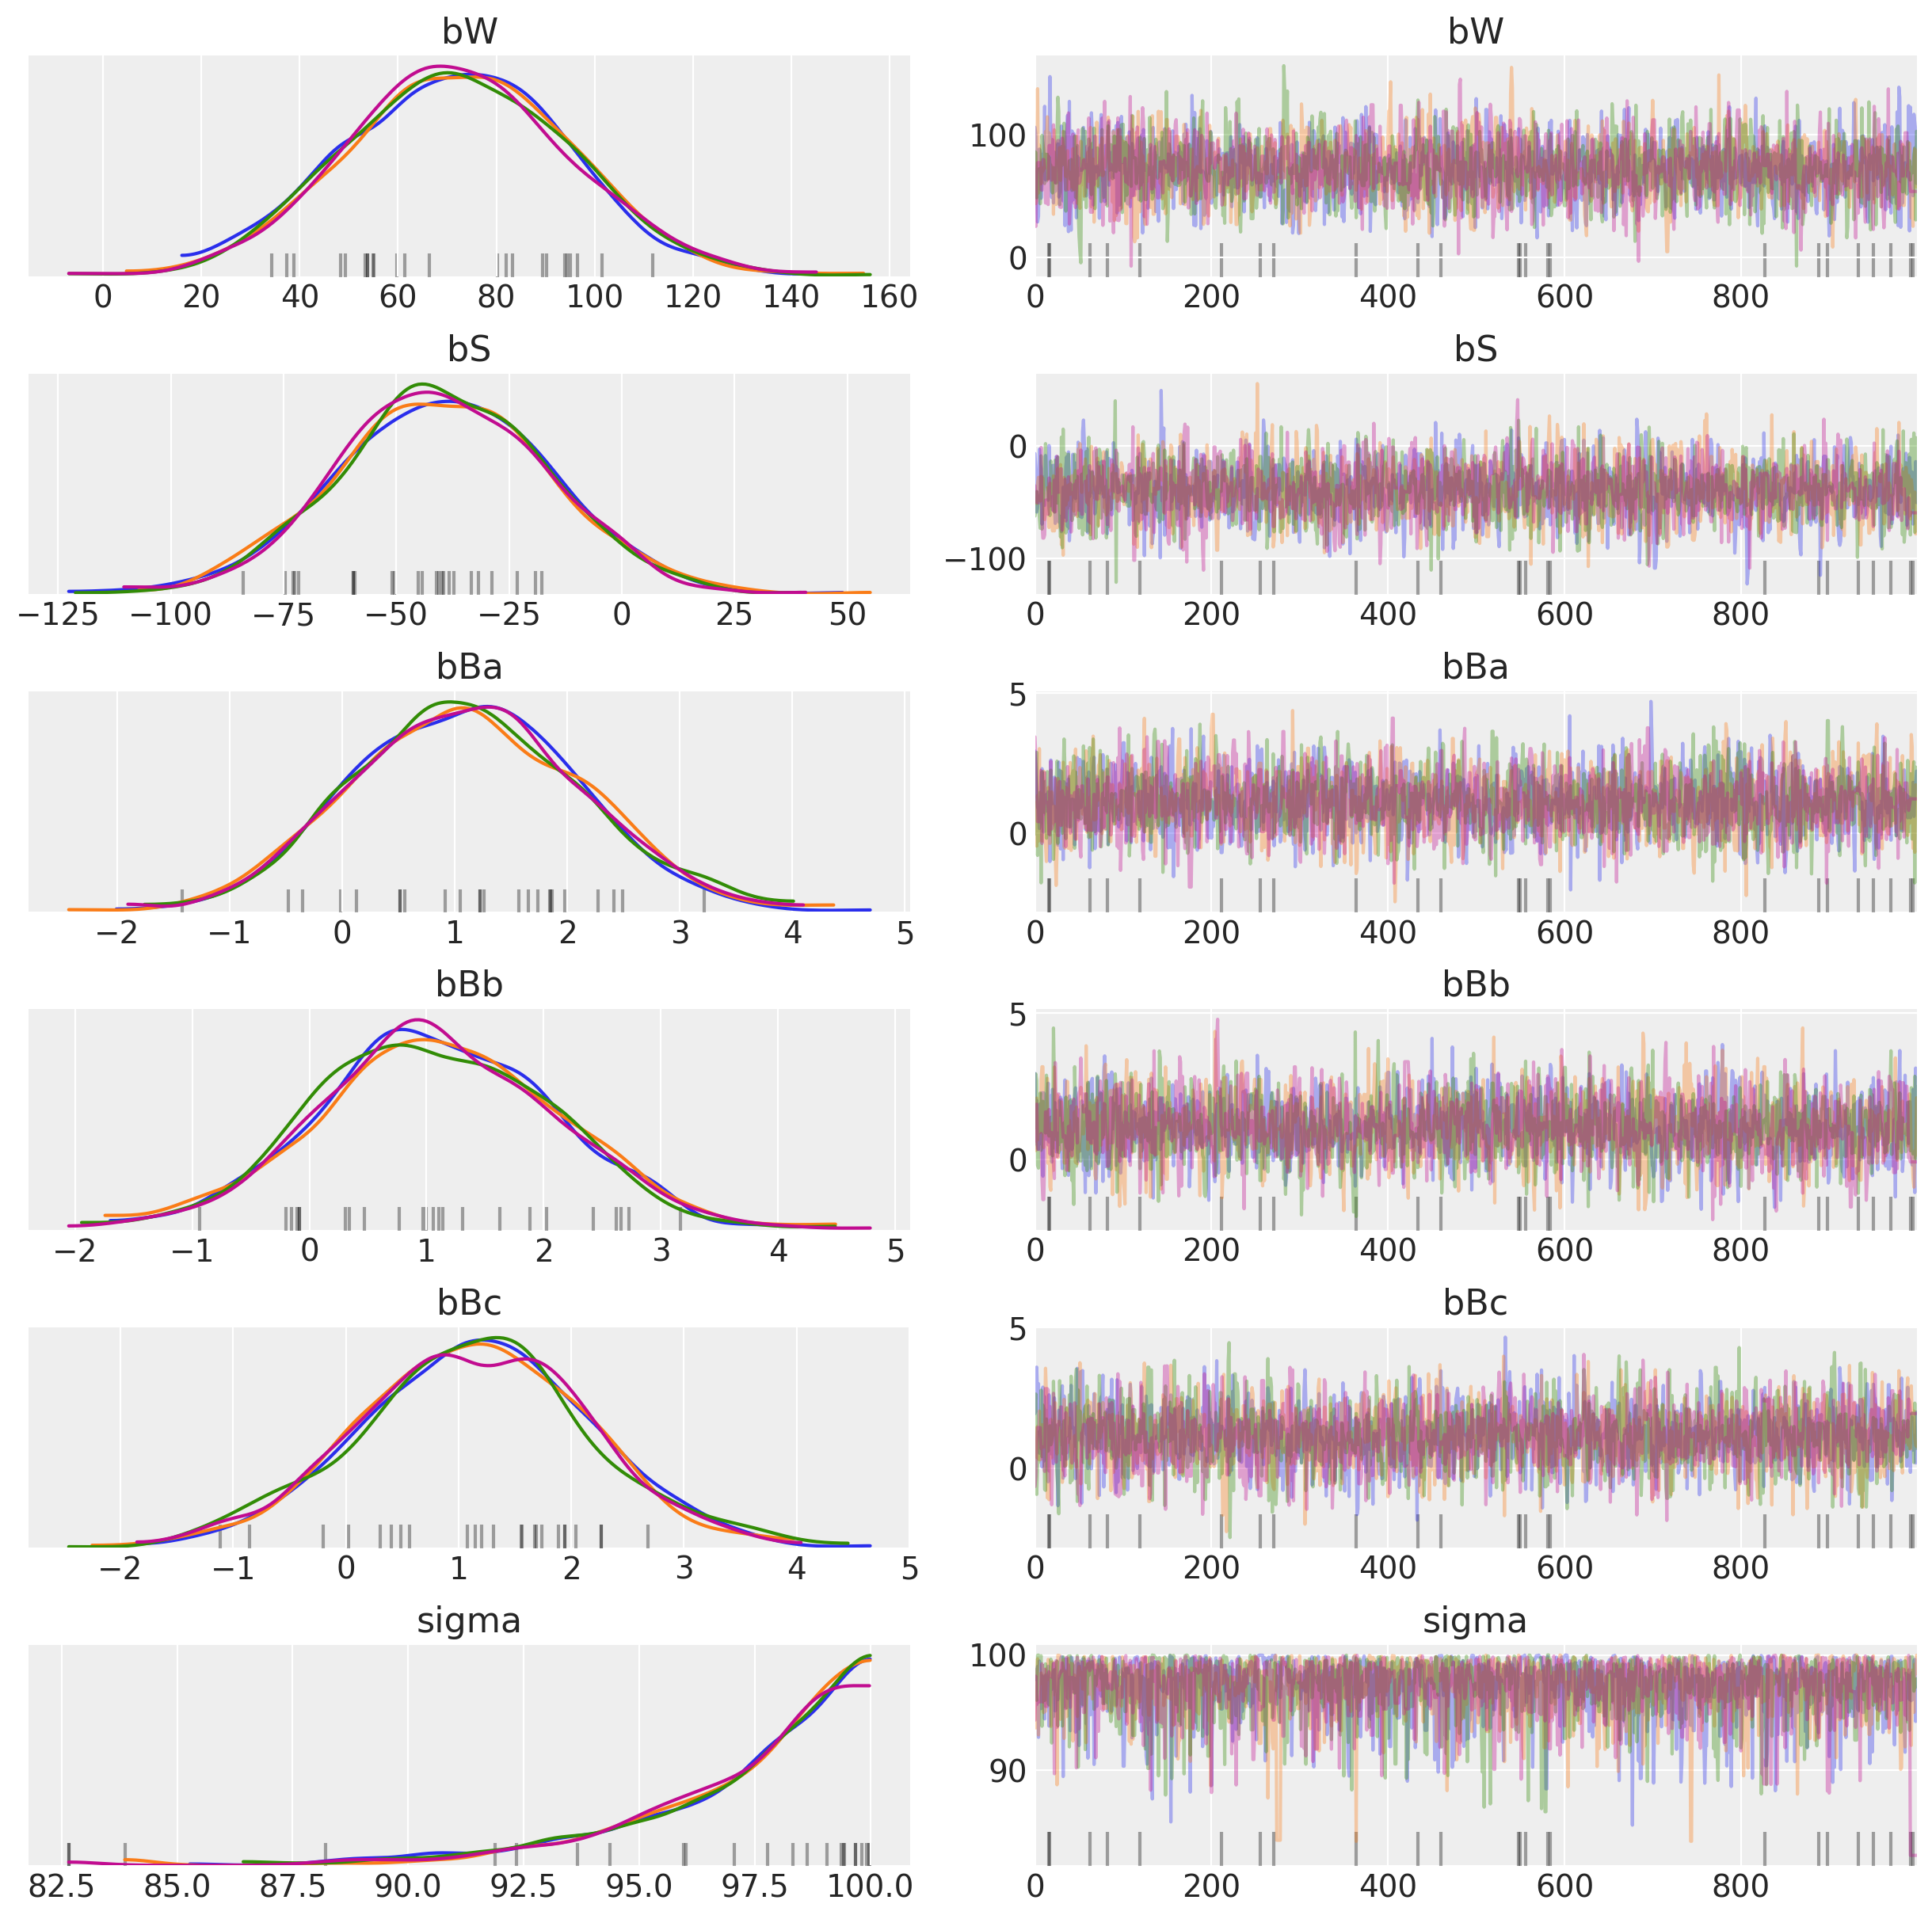

In [49]:
pm.traceplot(trace_m_h1, ['~mu']);

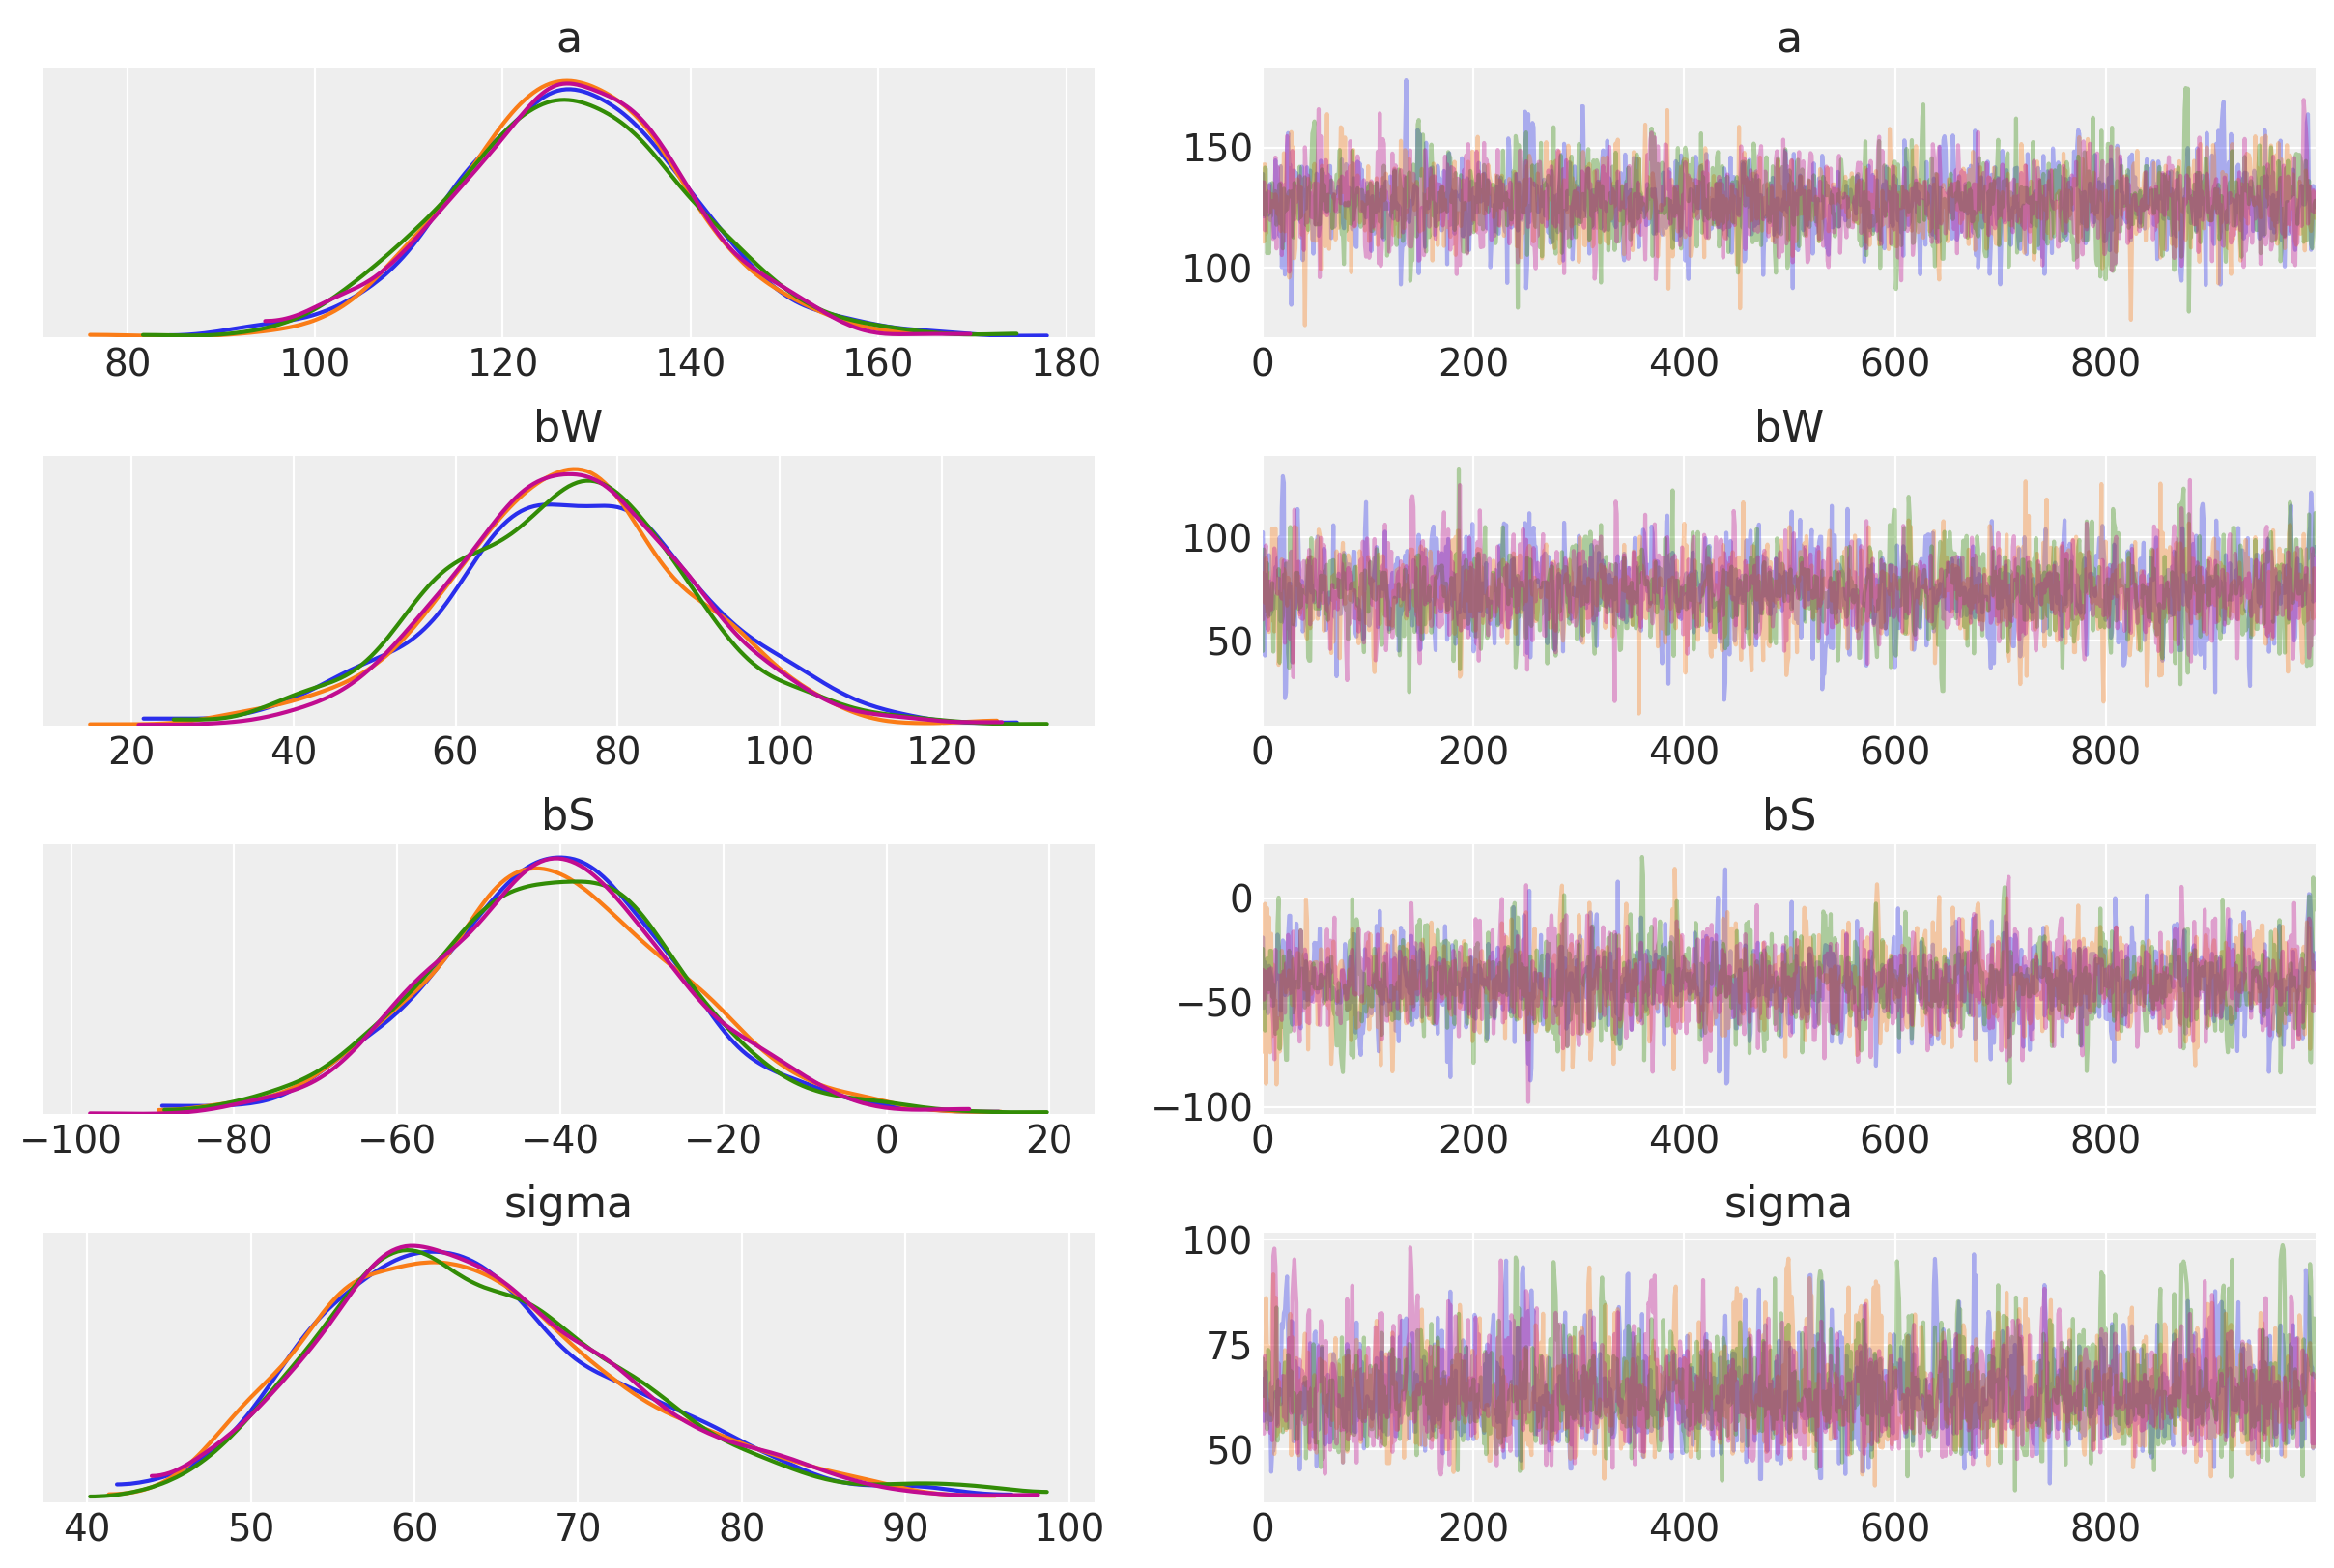

In [50]:
pm.traceplot(trace_m_h1_2, ['~mu']);

## 7H3

In [29]:
d = pd.read_csv('/Users/benjaminwee/Documents/courses/resources/Rethinking/Data/rugged.csv', sep=';', header=0)
#d.head()

# make log version of outcome
d['log_gdp'] = np.log(d.rgdppc_2000)

# extract countries with GDP data
dd = d[np.isfinite(d['rgdppc_2000'])]

dd_nos = dd[dd.country != 'Seychelles']

#dd = dd.reset_index(inplace=True, drop=True) 
#dd_nos = dd_nos.reset_index(inplace=True, drop=True) 

In [30]:
dd.reset_index(inplace=True, drop=True) 


In [32]:
dd_nos

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent,log_gdp
2,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,...,0,1,3610000.000,5.669,6.981,4.926,3.872,1223208.0,2.000,7.492609
4,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,...,0,0,0.000,NaN,NaN,NaN,NaN,200000.0,100.000,8.216929
7,ARE,784,United Arab Emirates,0.769,0.316,2.112,0.191,6.142,8360.0,23.913,...,0,0,0.000,NaN,NaN,NaN,NaN,19200.0,0.000,9.933263
8,ARG,32,Argentina,0.775,0.220,2.268,0.226,9.407,273669.0,-35.396,...,0,0,0.000,NaN,NaN,NaN,NaN,276632.0,89.889,9.407032
9,ARM,51,Armenia,2.688,0.934,8.178,0.799,50.556,2820.0,40.294,...,0,0,0.000,NaN,NaN,NaN,NaN,105743.0,0.500,7.792343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,WSM,882,Samoa,1.677,0.968,4.644,0.549,22.244,283.0,-13.738,...,0,0,0.000,NaN,NaN,NaN,NaN,33072.0,NaN,8.488849
230,YEM,887,Yemen,2.323,2.197,6.155,0.591,33.060,52797.0,15.863,...,0,0,0.000,NaN,NaN,NaN,NaN,2250000.0,0.000,6.669180
231,ZAF,710,South Africa,1.761,1.318,4.942,0.450,23.957,121447.0,-29.004,...,0,0,2030.663,6.766,3.457,6.584,4.895,486527.0,18.000,9.150497
232,ZMB,894,Zambia,0.533,0.506,1.422,0.145,2.455,74339.0,-13.458,...,0,0,27957.102,9.027,2.389,4.849,3.253,348220.0,1.000,6.651585


In [33]:
# With Seychelles
with pm.Model() as m_h3_1:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    bAR = pm.Normal('bAR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    gamma = bR + bAR * dd.cont_africa
    mu = pm.Deterministic('mu', a + gamma * dd.rugged + bA * dd.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_h3_1 = pm.sample(1000, tune=1000)
    
# Without Seychelles
with pm.Model() as m_h3_2:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    bAR = pm.Normal('bAR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    gamma = bR + bAR * dd_nos.cont_africa
    mu = pm.Deterministic('mu', a + gamma * dd_nos.rugged + bA * dd_nos.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd_nos.rgdppc_2000))
    trace_h3_2 = pm.sample(1000, tune=1000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1818.67draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1798.25draws/s]


In [34]:
az.summary(trace_h3_1, ['~mu'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,9.182,0.140,8.901,9.426,0.003,0.002,1853.0,1853.0,1855.0,2518.0,1.0
bR,-0.183,0.077,-0.331,-0.046,0.002,0.001,1746.0,1746.0,1746.0,2698.0,1.0
bA,-1.843,0.224,-2.249,-1.419,0.005,0.004,1886.0,1873.0,1884.0,2733.0,1.0
bAR,0.346,0.129,0.096,0.578,0.003,0.002,1962.0,1894.0,1967.0,2834.0,1.0
sigma,0.952,0.053,0.855,1.054,0.001,0.001,3920.0,3911.0,3923.0,2812.0,1.0


In [35]:
az.summary(trace_h3_2, ['~mu'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,9.183,0.141,8.920,9.444,0.003,0.002,1762.0,1762.0,1762.0,2389.0,1.0
bR,-0.184,0.078,-0.315,-0.031,0.002,0.001,1838.0,1838.0,1842.0,2427.0,1.0
bA,-1.776,0.227,-2.177,-1.329,0.005,0.004,1843.0,1843.0,1843.0,2398.0,1.0
bAR,0.246,0.141,-0.000,0.526,0.003,0.002,2151.0,2151.0,2150.0,2579.0,1.0
sigma,0.944,0.053,0.848,1.047,0.001,0.001,4083.0,4059.0,4097.0,2715.0,1.0


The effect of ruggedness has decreased and the interaction effect is smaller. Taking out Seychelles has redcued the resillience of Africa to rugged terrain in terms of log GDP. The overall slope is smaller.

In [43]:
with pm.Model() as m_h3_c1:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR * dd_nos.rugged)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd_nos.rgdppc_2000))
    trace_h3_c1 = pm.sample(1000, tune=1000)    
    
with pm.Model() as m_h3_c2:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR * dd_nos.rugged + bA * dd_nos.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd_nos.rgdppc_2000))
    trace_h3_c2 = pm.sample(1000, tune=1000)    
    
with pm.Model() as m_h3_c3:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    bAR = pm.Normal('bAR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    gamma = bR + bAR * dd_nos.cont_africa
    mu = pm.Deterministic('mu', a + gamma * dd_nos.rugged + bA * dd_nos.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd_nos.rgdppc_2000))
    trace_h3_c3 = pm.sample(1000, tune=1000)        

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bR, a]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2877.66draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, bR, a]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2348.33draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1881.72draws/s]


In [45]:
compare = az.compare({'m_h3_c1': trace_h3_c1,
                      'm_h3_c2' : trace_h3_c2,
                      'm_h3_c3' : trace_h3_c3})

compare

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_h3_c3,0,463.285,4.43014,0,0.736477,13.3477,0,True,deviance
m_h3_c2,1,466.221,3.90132,2.93639,0.263523,13.8649,3.18899,False,deviance
m_h3_c1,2,536.227,2.64026,72.9425,4.67158e-10,14.4953,14.6739,False,deviance


Inferences remain the same, there still exists a significant difference between continents when measuring log GDP with respect to ruggedness. Ommitting African dummy variable and pooling estimates has the weakest WAIC estimate and the least weight.